## 상태 업데이트 하기
- **HumanMassage**: 사용자(사람)의 메세지(질문)
- **AIMessage**: AI(LLM)의 메시지(답변)
- **AnyMessages**: 위 메시지들을 포함하는 메시지

In [6]:
 from langchain_core.messages import AnyMessage
 from typing_extensions import TypedDict

 class State(TypedDict):
    messages: list[AnyMessage] # messages는 AnyMessage 객체들의 리스트이다.

In [11]:
from langchain_core.messages import AIMessage

def node(state: State):
    messages = state['messages']
    new_msg = AIMessage('안녕하세요, 무엇을 도와드릴까요?')

    # return {'messages': new_msg} # 기존 메세지를 대처(덮어쓰기 방식)
    return {'messages': messages + [new_msg]} # 기존 메시지 형식에 새로운 메시지 형식을 합침.

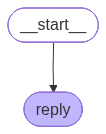

In [12]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node('reply', node)
graph_builder.set_entry_point('reply')
graph = graph_builder.compile()

graph


In [13]:
from langchain_core.messages import HumanMessage

result = graph.invoke({'messages': [HumanMessage('안녕')]})
result

{'messages': [HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}),
  AIMessage(content='안녕하세요, 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})]}

## 대화 메시지 상태 누적하기
```from langgraph.graph.message import add_messages```

In [14]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
def node(state: State):
    messages = state['messages']
    new_msg = AIMessage('안녕하세요, 무엇을 도와드릴까요?')

    return {'messages': new_msg}

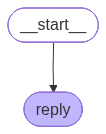

In [16]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node('reply', node)
graph_builder.set_entry_point('reply')  
graph = graph_builder.compile()

graph

In [20]:
# input_msg = {'role': 'user', 'content': '안녕'}
# result = graph.invoke({'messages': [input_msg]})

result = graph.invoke({'messages': [HumanMessage('안녕')]})

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요, 무엇을 도와드릴까요?


In [21]:
result["messages"]

[HumanMessage(content='안녕', additional_kwargs={}, response_metadata={}, id='6de3803d-ab84-4ea7-a6f9-926cf24b38b8'),
 AIMessage(content='안녕하세요, 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='ba655830-d3a7-4422-afce-ab12a5c72924')]

## 노드와 엣지 연결하기

## 

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    value1: str
    value2: int

In [2]:
def step1(state: State):
    return {'value1': state['value1']}

def step2(state: State):
    current_value1 = state['value1']
    return {'value1': f'{current_value1} b'}

def step3(state: State):
    return {'value2': 10}

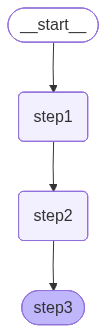

In [3]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(State)

graph_builder.add_node('step1', step1)
graph_builder.add_node('step2', step2)
graph_builder.add_node('step3', step3)

graph_builder.add_edge(START, 'step1')
graph_builder.add_edge('step1', 'step2')
graph_builder.add_edge('step2', 'step3')
graph = graph_builder.compile()

graph

In [4]:
graph.invoke({'value1': 'jinwoo'})

{'value1': 'jinwoo b', 'value2': 10}

## 한번에 연결한기

In [5]:
graph.builder = StateGraph(State).add_sequence([step1, step2, step3])
graph_builder.add_edge(START, 'step1')

graph = graph_builder.compile()
graph.invoke({'value1': 'code_666'})

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


{'value1': 'code_666 b', 'value2': 10}

## 병렬로 연결하기

In [7]:
import operator
from typing_extensions import Annotated, TypedDict
# from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add] # aggregate는 리스트 타입이며, 
                                             #operator.add 연산자를 사용하여 값을 합친다.

In [10]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {'aggregate': ['A']}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {'aggregate': ['B']}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {'aggregate': ['C']}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {'aggregate': ['D']}

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node('A', a)
graph_builder.add_node('B', b)
graph_builder.add_node('C', c)
graph_builder.add_node('D', d)

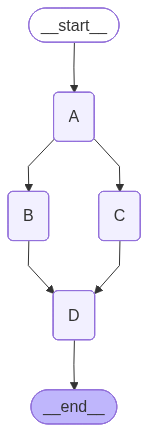

In [14]:
graph_builder.add_edge(START, 'A')
graph_builder.add_edge('A', 'B')
graph_builder.add_edge('A', 'C')
graph_builder.add_edge('B', 'D')
graph_builder.add_edge('C', 'D')
graph_builder.add_edge('D', END)
graph = graph_builder.compile()

graph

In [15]:
graph.invoke({'aggregate': []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

## 조건부 엣지 병렬 연결하기

In [16]:
import operator
from typing_extensions import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which: str

In [17]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

In [18]:
graph_builder = StateGraph(State)

graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)
graph_builder.add_node(e)
graph_builder.add_edge(START, "a")

In [ ]:
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state['which'] == 'cd':
        return ['c', 'd']
    else:
        return ['b', 'c']
    
intermediates = ['b', 'c', 'd']
graph_builder.add_conditional_edges(
    'a',
    route_bc_or_cd,
    intermediates,
)

# -> Sequence[str]:
# - 조건 분기 함수(route)가 반환해야 하는 "노드 이름들의 순서 목록"을 의미한다.
# - LangGraph는 이 리스트를 그대로 "다음 실행 경로"로 사용한다.
#   예) ['c', 'd'] → c 실행 후 d 실행
#       ['b', 'c'] → b 실행 후 c 실행
# - 즉, 단순 타입힌트가 아니라, LangGraph가 "다음에 어떤 노드를 어떤 순서로 실행할지"
#   판단하는 공식적인 실행 경로 포맷이다.
# - 쉽게 말해:
#   조건을 보고 → ['c','d'] 또는 ['b','c'] 같은 리스트를 반환하고 →
#   LangGraph는 그 리스트 순서대로 노드를 실행한다.

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


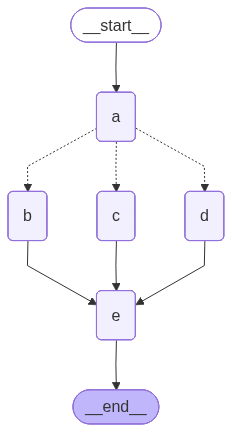

In [22]:
for node in intermediates:
    graph_builder.add_edge(node, 'e')

graph = graph_builder.add_edge('e', END)
graph = graph_builder.compile()

graph

In [23]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [24]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}